###Project Name : Animal Faces Image Classification Deployment
###Project Description : This project is an implementation of an image classification model using Conv2D and Maxpooling Layer. The model is designed to classify a dataset of animal faces with a minimum training and validation set accuracy target of 80%. In this project, I use callbacks to improve training efficiency, as well as create visualization plots to see the trend of accuracy and model loss. In addition, code is included to save the model into TF-Lite format, enabling lightweight and efficient deployment of the model on various platforms.
###Dataset : https://www.kaggle.com/datasets/andrewmvd/animal-faces
###Tools : Google Colaboratory

In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baharuddinnurm","key":"dfbbd9dfa2f0bc24956bc3c4ff6092ae"}'}

In [ ]:
#create a kaggle folder
! mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/animal-faces

 98% 681M/696M [00:09<00:00, 98.3MB/s]
100% 696M/696M [00:09<00:00, 74.5MB/s]


In [ ]:
#melakukan ekstraksi pada file zip
!unzip animal-faces.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: afhq/train/wild/flickr_wild_001378.jpg  
  inflating: afhq/train/wild/flickr_wild_001379.jpg  
  inflating: afhq/train/wild/flickr_wild_001380.jpg  
  inflating: afhq/train/wild/flickr_wild_001381.jpg  
  inflating: afhq/train/wild/flickr_wild_001382.jpg  
  inflating: afhq/train/wild/flickr_wild_001384.jpg  
  inflating: afhq/train/wild/flickr_wild_001385.jpg  
  inflating: afhq/train/wild/flickr_wild_001386.jpg  
  inflating: afhq/train/wild/flickr_wild_001387.jpg  
  inflating: afhq/train/wild/flickr_wild_001388.jpg  
  inflating: afhq/train/wild/flickr_wild_001389.jpg  
  inflating: afhq/train/wild/flickr_wild_001390.jpg  
  inflating: afhq/train/wild/flickr_wild_001391.jpg  
  inflating: afhq/train/wild/flickr_wild_001392.jpg  
  inflating: afhq/train/wild/flickr_wild_001393.jpg  
  inflating: afhq/train/wild/flickr_wild_001394.jpg  
  inflating: afhq/train/wild/flickr_wild_001395.jpg  
  inflating: afhq/train

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
base_dir = '/content/afhq'
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [ ]:
os.listdir(train_dir)

['dog', 'wild', 'cat']

In [ ]:
os.listdir(val_dir)

['dog', 'wild', 'cat']

In [ ]:
train_dog_dir = os.path.join(train_dir,'dog')
train_wild_dir = os.path.join(train_dir,'wild')
train_cat_dir = os.path.join(train_dir,'cat')

validation_dog_dir = os.path.join(val_dir,'dog')
validation_wild_dir = os.path.join(val_dir,'wild')
validation_cat_dir = os.path.join(val_dir,'cat')

In [ ]:
#melakukan split folder dengan menggunakan ImageDataGenerator()
datagen = ImageDataGenerator(validation_split=0.2,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

In [ ]:
train_gene= datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(224,224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

validation_gene= datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(224,224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 11706 images belonging to 3 classes.
Found 2924 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
int_lr = 1e-4

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.94):
      print('\nAkurasi lebih dari 94%')



callbacks = myCallback()

In [ ]:
history=model.fit(
    train_gene,
    steps_per_epoch=25,
    epochs=30,
    validation_data=validation_gene,
    verbose=1,
    callbacks=[callbacks])

Epoch 1/30
25/25 [==============================] - 52s 2s/step - loss: 0.1962 - accuracy: 0.9337 - val_loss: 0.2381 - val_accuracy: 0.9138
Epoch 2/30
25/25 [==============================] - 52s 2s/step - loss: 0.1888 - accuracy: 0.9362 - val_loss: 0.2764 - val_accuracy: 0.8981
Epoch 3/30
25/25 [==============================] - 51s 2s/step - loss: 0.1855 - accuracy: 0.9362 - val_loss: 0.2353 - val_accuracy: 0.9135
Epoch 4/30
25/25 [==============================] - 51s 2s/step - loss: 0.1732 - accuracy: 0.9362 - val_loss: 0.2361 - val_accuracy: 0.9114
Epoch 5/30
25/25 [==============================] - 52s 2s/step - loss: 0.1882 - accuracy: 0.9300 - val_loss: 0.2985 - val_accuracy: 0.8847
Epoch 6/30
25/25 [==============================] - 52s 2s/step - loss: 0.1980 - accuracy: 0.9250 - val_loss: 0.3148 - val_accuracy: 0.8830
Epoch 7/30
25/25 [==============================] - 51s 2s/step - loss: 0.1852 - accuracy: 0.9337 - val_loss: 0.2338 - val_accuracy: 0.9155
Epoch 8/30
25/25 [==

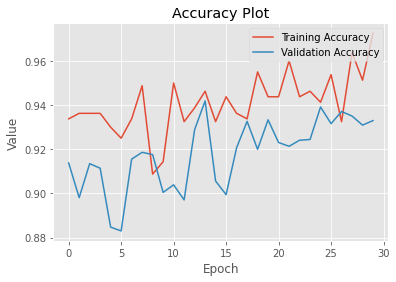

In [ ]:
plt.style.use('ggplot')
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


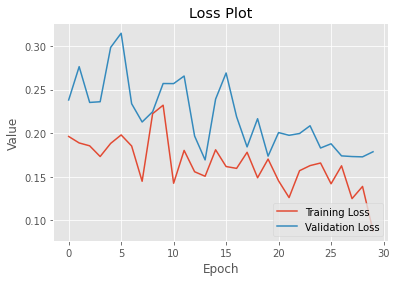

In [ ]:
plt.style.use('ggplot')
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with tf.io.gfile.GFile('model.tflite','wb') as f:
  f.write(tflite_model)

In [ ]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  38724500 Sep  3 05:21 model.tflite
